# Objective

> 각자 생각하고 있는 프로젝트의 방향성에 대해 공유할 필요가 있다고 생각이 들어서, 우선 제가 생각해 놓았던 방향에 대한 예시들을 아래에 서술해보고자 합니다.


# 기준

1. 데이터가 복잡해서, 데이터를 전처리하는 데에 시간이 많이 걸리는 건 좋지 못하다고 생각. 그래서 데이터는 굉장히 심플해야 한다.
2. 데이터가 적어 언더피팅 문제가 발생해서, 학습이 잘 안되는 것도 문제이다. 그러므로 데이터의 모수가 많아야 한다.
3. 다양한 문제를 다룰 수 있어야 한다. 

# 결론
> 이러한 고민이 들어서, `MNIST`를 활용해서 여러가지 분석을 해보면 어떨까 생각이 들었습니다.

1. MNIST는 데이터가 단순합니다. 그래서 학습도 빠르고, 전처리도 굉장히 쉽습니다.
2. MNIST는 기본적으로 6만개의 데이터셋을 가지고 있으므로, 언더피팅이 잘 발생하지 않습니다. 아주 좋죠.
3. MNIST는 기본적으로 Classification 문제로 디자인된 문제입니다. 하지만 아래 같이 다양한 방법을 통해 문제를 만들어보면 어떨까요?

## 환경설정

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os

from tensorflow.examples.tutorials.mnist import input_data

## (1) 데이터 가져오기

In [109]:
os.makedirs("../data/",exist_ok=True)
mnist = input_data.read_data_sets("../data/MNIST_data/")

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [20]:
images = mnist.train.images.reshape(-1,28,28)
labels = mnist.train.labels

## Original 문제 
> 아래의 이미지를 보고 무슨 숫자인지 맞추어라

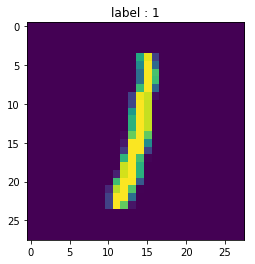

In [32]:
idx = 4
image = images[idx]
label = labels[idx]

plt.title(f"label : {label}")
plt.imshow(image)
plt.show()

> 이거는 1990년대부터 이미 풀린 문제다. 

이 문제가 쉬운 점은 일단 중앙에 사물이 존재한다는 것이다.

## Upgrade 문제 (1) : Localization 문제

> 사물이 이제 중앙에 정렬되지 않은 상태로 한번 만들어보자

In [43]:
def attach_background(image, bg_size=(100,100)):
    background = np.random.normal(0.1,0.1, bg_size) # 약간의 노이즈를 끼얹음
    
    h_bg, w_bg = background.shape
    h_fg, w_fg = image.shape # fg : foreground
    
    x = np.random.randint(0, w_bg-w_fg-1)
    y = np.random.randint(0, h_bg-h_fg-1)
    
    background[y:y+h_fg,x:x+w_fg] += image
    return background, (x, y)

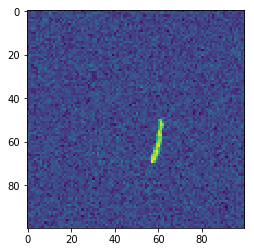

In [45]:
idx = 4
image = images[idx]
label = labels[idx]

image_with_bg, position = attach_background(image)
plt.imshow(image_with_bg)
plt.show()

우리는 이제 문제가 2가지로 나뉘어진다. 

1. 숫자가 어디에 있는가?
2. 해당 숫자가 어떤 수를 가르키는가? 

해당 문제를 컴퓨터 비전에서는 Localization 문제라고 불린다. 이제 우리는 아래 같이 문제를 맞추어야 한다. 

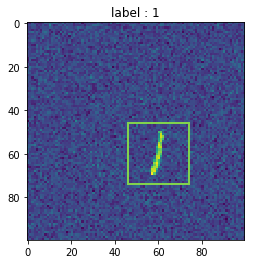

In [53]:
x,y = position
prediction = cv2.rectangle(image_with_bg,(x,y),(x+28,y+28),(1,0,0))

plt.imshow(prediction)
plt.title(f"label : {label}")
plt.show()

그래서 우리는 좌표의 위치를 Regression하면서, 해당 위치에 있는 숫자를 Classification 해야 하는, 2가지의 문제를 풀게 된다. 

## Upgrade 문제 (2) : Multiple Serialized Number 문제

> 숫자가 일직선으로 나란히 붙어있다고 생각해보자. 

In [97]:
def generate_random_serialized_number(digit=5):
    """
    MNIST의 숫자들을 랜덤으로 일렬로 붙인 것을 반환
    
    digit : 몇 개의 숫자를 붙일것인지를 결정
    """
    global images, labels # 전역변수에 있는 MNIST 값 가져오기
    idx = np.random.randint(0, len(images), digit)
    
    # 종방향으로 붙임
    batch_image = images[idx]
    seq_image = batch_image.transpose((1,0,2)).reshape(28,-1)

    
    # string으로 변환
    batch_labels = labels[idx]
    seq_label = "".join([str(num) for num in batch_labels])
    
    # background noise를 더함
    background = np.random.normal(0.1,0.1, seq_image.shape)
    seq_image += background

    return seq_image, seq_label

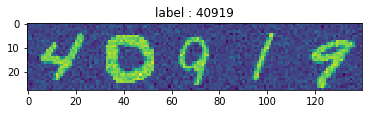

In [100]:
seq_image, seq_label = generate_random_serialized_number(5)

plt.title(f"label : {seq_label}")
plt.imshow(seq_image)
plt.show()

우리는 이제 하나의 순차적으로 숫자의 배열을 하나씩 맞추어 나가는 식의 문제로 바꾸었다. 지금은 등간격으로 배치되어 있지만, 간격이 등간격이 아니거나, 글자의 크기가 완전히 다르기 시작하면 문제는 굉장히 난해해진다. 

## Upgrade 문제 (3) : Detection 문제

> 숫자가 하나만 있지 않고 여러개가 랜덤하게 박혀있다고 생각해보자.

In [102]:
def generate_random_numbers(digit=3, bg_size=(112,112)):
    global images, labels # 전역변수에 있는 MNIST 값 가져오기
    
    background = np.random.normal(0.1,0.1, bg_size) # 약간의 노이즈를 끼얹음
    h_bg, w_bg = background.shape
    
    idxs = np.random.randint(0, len(images), digit)
    
    positions = []
    for idx in idxs:
        image = images[idx]
        label = labels[idx]
        
        h_fg, w_fg = image.shape # fg : foreground
    
        x = np.random.randint(0, w_bg-w_fg-1)
        y = np.random.randint(0, h_bg-h_fg-1)
    
        background[y:y+h_fg,x:x+w_fg] += image    
        positions.append((x,y,label))
        
    return background, positions

In [107]:
image_with_bg, positions = generate_random_numbers(digit=5)

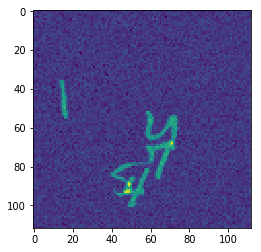

In [108]:
plt.imshow(image_with_bg)
plt.show()

여기서부터 골때리기 시작한다. 사물이 겹쳐있을 수도 있고, 사물이 몇개가 있다고 보장할 수도 없다. 그렇기 때문에 Detection문제는 Computer Vision 문제에서 굉장히 나주에 풀리기 시작한 문제이기도 하다.

이거 풀려고 Mask-RCNN, Retinanet, SSD가 나왔다. 이런 알고리즘 모두 여기에 다 적용가능하니, 한번 적용하면서 공부해보자. 

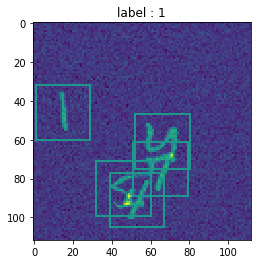

In [113]:
prediction = image_with_bg.copy()
for position in positions:
    x,y,_ = position
    prediction = cv2.rectangle(prediction,(x,y),(x+28,y+28),(1,0,0))

plt.imshow(prediction)
plt.title(f"label : {label}")
plt.show()

-----

# 제안

> 위와 같은 방식으로 접근하면 아래와 같은 장점이 있습니다.

1. 위와 같이 접근하면 난이도도 굉장히 쉽게 조절 가능. 
    
    예를들어, 글자의 크기를 다양하게 한다던지, 글자를 회전시킨다던지, Morphing을 통해 글자를 비튼다던지 다양한 시도로 난이도를 쉽게 높일 수 있다.
    
2. 비용이 적게 듦. 

    MNIST는 데이터의 모수 갯수에 비해 저장 공간을 많이 먹지 않고, 학습량도 적어서 Colab같은 환경에서도 무리 없이 돌릴 수 있다. 
    
3. 